drzewo decyzyjne: https://www.kaggle.com/jiashenliu/who-can-earn-more-than-50k-per-year
outliers: https://www.kaggle.com/kazimanil/adult-census-income-classification



In [31]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB



In [2]:
df = pd.read_csv('./census-income.csv')

In [3]:
def replace_nans(df):
    df = df.replace(' Not in universe', np.nan)
    df = df.replace(' ?', np.nan)
    df = df.replace(' Not in universe or children', np.nan)
    return df

In [4]:
def map_categories(df):
    education_mapping = {" Children": 0,
                     " Less than 1st grade": 1,
                     " 1st 2nd 3rd or 4th grade": 2,
                     " 5th or 6th grade": 3,
                     " 7th and 8th grade": 4,
                     " 9th grade": 5,
                     " 10th grade": 6,
                     " 11th grade": 7,
                     " 12th grade no diploma": 8,
                     " High school graduate": 9,
                     " Some college but no degree": 10,
                     " Associates degree-occup /vocational": 11,
                     " Associates degree-academic program": 12,
                     " Bachelors degree(BA AB BS)": 13,
                     " Masters degree(MA MS MEng MEd MSW MBA)": 14,
                     " Doctorate degree(PhD EdD)": 15,
                     " Prof school degree (MD DDS DVM LLB JD)": 16}

    df = df.replace(education_mapping)
    df['education'] = df['education'].astype('category')
    
    # salary mapping
    salary_mapping = {' - 50000.': 0,
                     ' 50000+.': 1}
    df = df.replace(salary_mapping)
    
    # maritial status mapping
    maritial_mapping = {'divorced': [' Divorced'],
                       'single': [' Never married', ' Widowed'],
                       'married': [' Married-A F spouse present', 
                                   ' Married-civilian spouse present',
                                  ' Married-spouse absent', ' Separated']}
    df = df.replace('divocred', 'divorced')
    df = df.replace([' Never married', ' Widowed'], 'single')
    df = df.replace(maritial_mapping['married'], 'married')
    
    # citizenship status mapping
    citizenship_mapping = {'native': [' Native- Born in the United States',
                                      ' Native- Born in Puerto Rico or U S Outlying',
                                      ' Native- Born abroad of American Parent(s)'],
                        'foreign': [' Foreign born- Not a citizen of U S ',
                                   ' Foreign born- U S citizen by naturalization'],
                       }
    df = df.replace(citizenship_mapping['native'], 'native')
    df = df.replace(citizenship_mapping['foreign'], 'foreign')
    return df

In [5]:
def transform_to_one_hot(df):
    def remove_col_append_dummies(dataset, col_name):
    # z danej kolumny robie dummies 
        prefix = 'col_' + str(col_name)
        dummies = pd.get_dummies(dataset[col_name], prefix=prefix)
        dataset = df.drop(col_name, axis=1)
        dataset = pd.concat([dataset, dummies], axis=1)
        return dataset
    # zamiana w one hot
    cats_to_one_hot = ['class of worker', 'marital stat', 'major industry code', 
                       'major occupation code', 'race', 'reason for unemployment',
                      'full or part time employment stat', 'tax filer stat', 'sex']
    for c in cats_to_one_hot:
        df = remove_col_append_dummies(df, c)
    return df

In [6]:
def drop_redundand_columns(df):
    df = df.drop(['detailed industry recode', 'detailed occupation recode',
             'enroll in edu inst last wk', 'hispanic origin', 'instance weight',
             'live in this house 1 year ago', 'migration prev res in sunbelt',
             'year', 'state of previous residence', 'region of previous residence'], axis=1)
    return df

In [7]:
def normalize_col(dataset, col_name):
    return ((dataset[col_name]-dataset[col_name].min()) / 
                       (dataset[col_name].max() - dataset[col_name].min()))

In [9]:
def normalize_data(df):
    df['dividends from stocks'] = normalize_col(df, 'dividends from stocks')
    df['weeks worked in year'] = normalize_col(df, 'weeks worked in year')
    df['capital gains'] = normalize_col(df, 'capital gains')
    df['capital losses'] = normalize_col(df, 'capital losses')
    df['wage per hour'] = normalize_col(df, 'wage per hour')
    
#     df['education'] = normalize_col(df, 'education')
#     df['age'] = normalize_col(df, 'age')

    
    return df

Cały preprocessing, zamiana '?' na nany, usuwanie kolumn których nie używamy a są numeryczne, mapowanie kategorii, transformacja kategorii do one-hot oraz normalizacja danych.

In [10]:
def prepare_data(df):
    df = replace_nans(df)
    df = drop_redundand_columns(df)
    df = map_categories(df)
    df = transform_to_one_hot(df)
    df = normalize_data(df)
    return df

In [11]:
df = prepare_data(df)
df.head()

KeyError: "['detailed industry recode' 'detailed occupation recode'\n 'enroll in edu inst last wk' 'hispanic origin' 'instance weight'\n 'live in this house 1 year ago' 'migration prev res in sunbelt' 'year'\n 'state of previous residence' 'region of previous residence'] not found in axis"

In [119]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.columns, len(numerical_features.columns)

(Index(['age', 'education', 'wage per hour', 'capital gains', 'capital losses',
        'dividends from stocks', 'num persons worked for employer',
        'own business or self employed', 'veterans benefits',
        'weeks worked in year', 'year', 'salary',
        'col_class of worker_ Federal government',
        'col_class of worker_ Local government',
        'col_class of worker_ Never worked', 'col_class of worker_ Private',
        'col_class of worker_ Self-employed-incorporated',
        'col_class of worker_ Self-employed-not incorporated',
        'col_class of worker_ State government',
        'col_class of worker_ Without pay', 'col_marital stat_ Divorced',
        'col_marital stat_married', 'col_marital stat_single',
        'col_major industry code_ Agriculture',
        'col_major industry code_ Armed Forces',
        'col_major industry code_ Business and repair services',
        'col_major industry code_ Communications',
        'col_major industry code_ Construc

Tutaj widzę które dane nie są zawarte. Widać, że enroll in edu inst last wk można zupełnie pominąć. Co do innych należy się zastanowić.

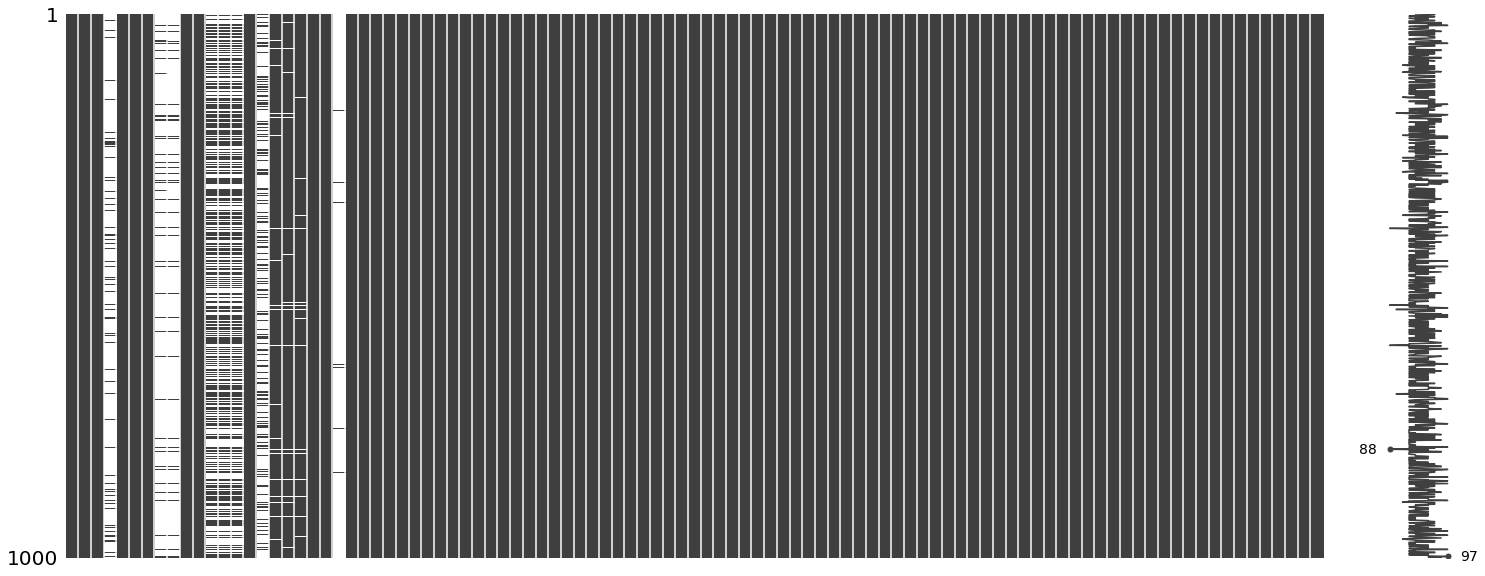

In [230]:
msno.matrix(df.sample(1000))

Tutaj widzę które brakujące wartości są ze sobą powiązane. Tzn. jeśli nie ma "major industry code" to nie ma również "major occupation code". Co ciekawe istnieje ujemna korelacja dla "famili member under 18". Trzeba to zbadać.

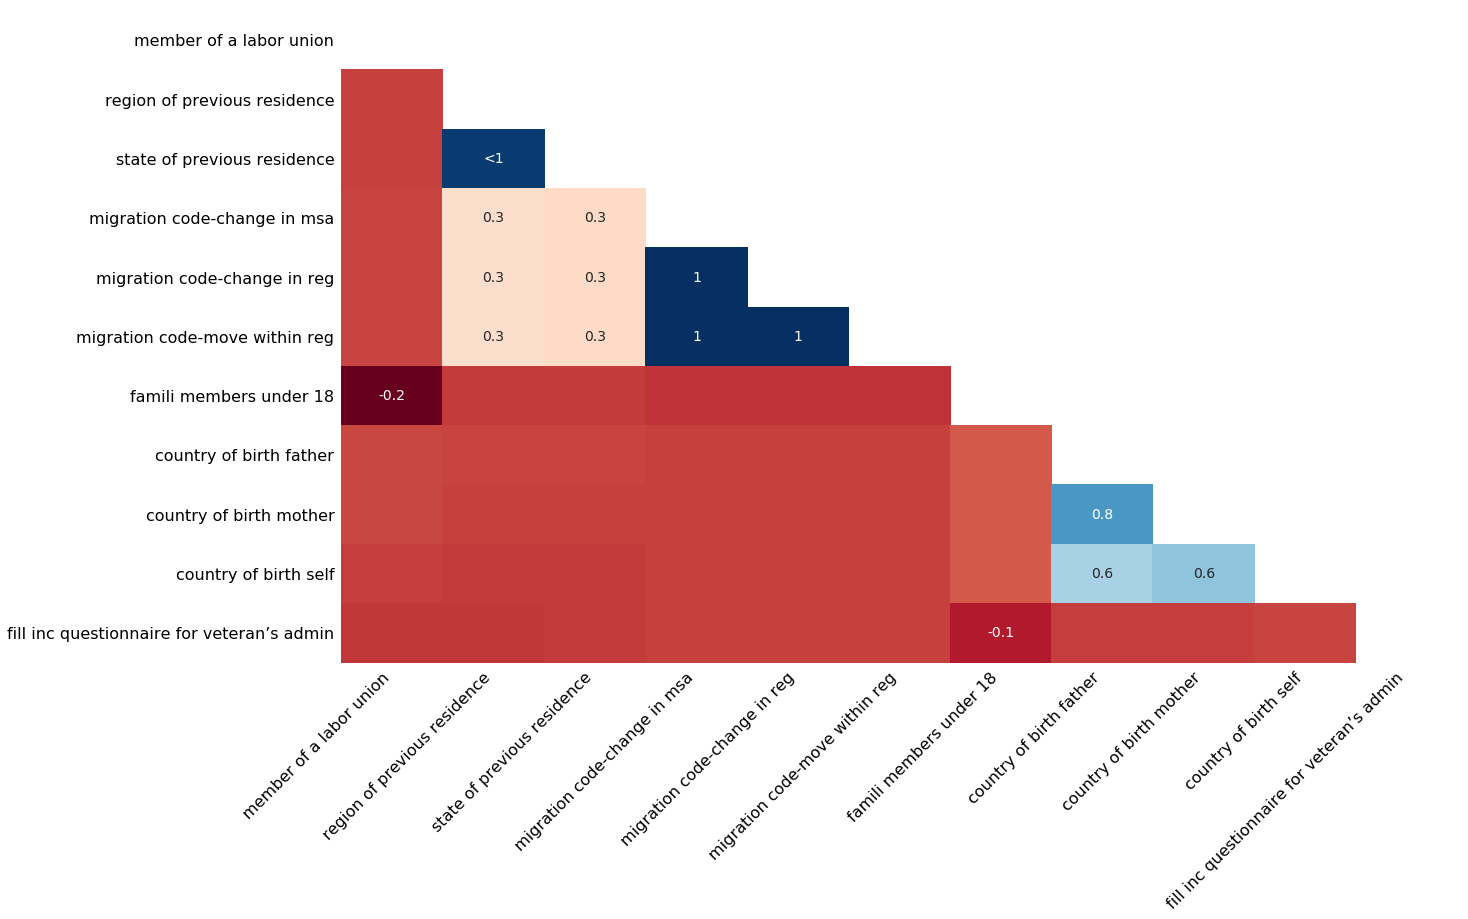

In [231]:
msno.heatmap(df)

Ile pustych rekordów dla kategorycznych rekordów:

In [232]:
cat_df = df.select_dtypes(include=['object', 'category']).copy()
cat_df.isnull().sum()

member of a labor union                       180459
region of previous residence                  183750
state of previous residence                   184458
detailed household and family stat                 0
detailed household summary in household            0
migration code-change in msa                  101212
migration code-change in reg                  101212
migration code-move within reg                101212
famili members under 18                       144232
country of birth father                         6713
country of birth mother                         6119
country of birth self                           3393
citizenship                                        0
fill inc questionnaire for veteran’s admin    197539
dtype: int64

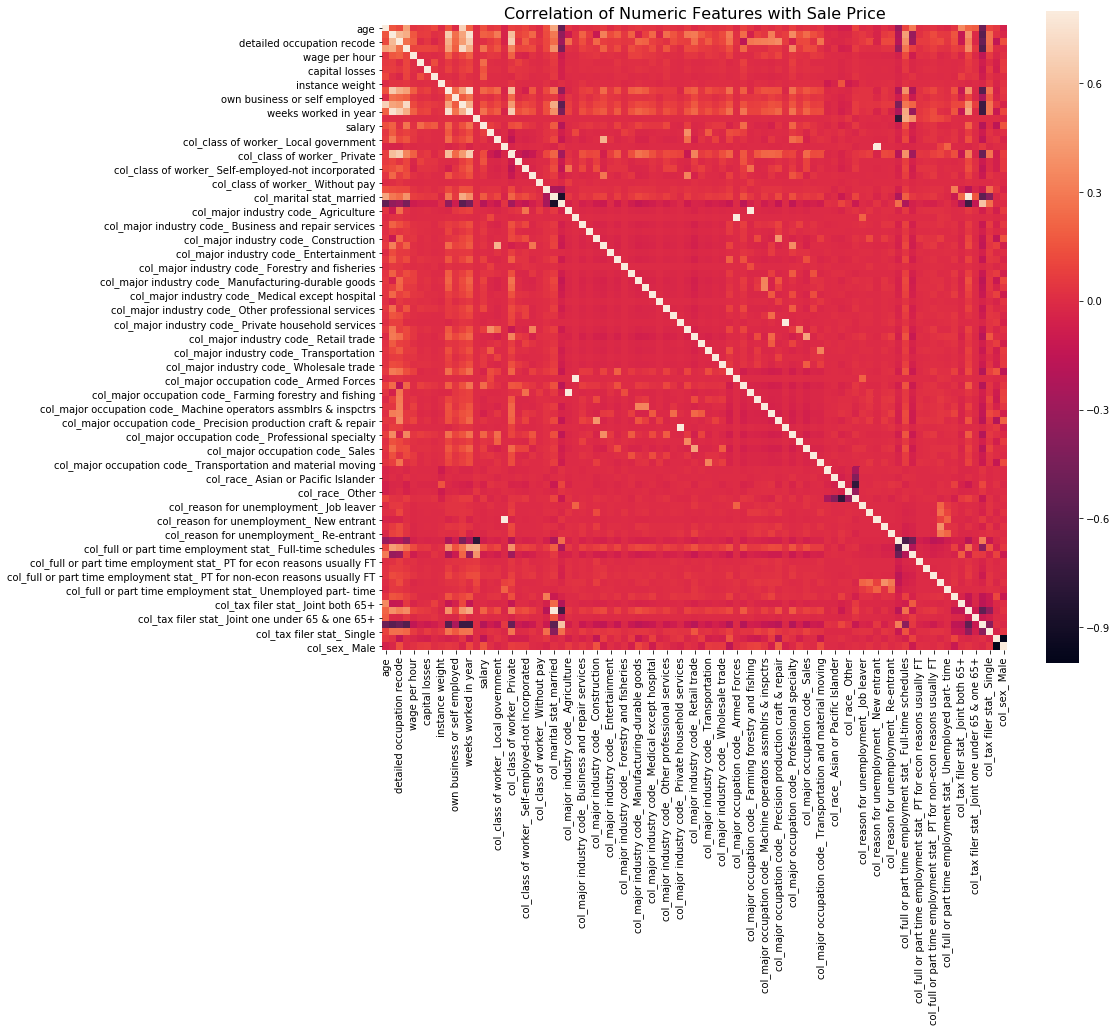

In [233]:
correlation = numerical_features.corr()
f , ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)

In [19]:
data_corr=df.corr(method='pearson')
data_corr.sort_values('salary').salary

col_tax filer stat_ Nonfiler                                       -0.198326
col_marital stat_single                                            -0.189925
col_sex_ Female                                                    -0.157610
col_full or part time employment stat_ Children or Armed Forces    -0.077344
col_full or part time employment stat_ Not in labor force          -0.073197
col_major occupation code_ Other service                           -0.054909
col_race_ Black                                                    -0.049827
col_major occupation code_ Adm support including clerical          -0.037592
col_major occupation code_ Handlers equip cleaners etc             -0.025852
col_reason for unemployment_ Re-entrant                            -0.021233
col_race_ Other                                                    -0.021054
col_major industry code_ Retail trade                              -0.020078
col_major occupation code_ Machine operators assmblrs & inspctrs   -0.018996

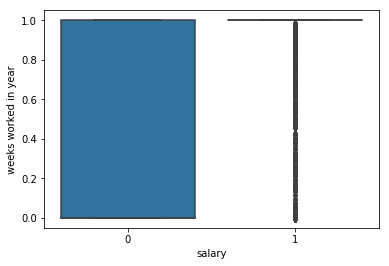

In [234]:
sns.boxplot(x=df['salary'], y=df['weeks worked in year'])

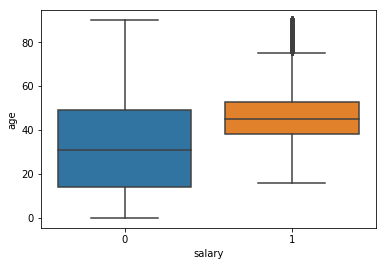

In [235]:
sns.boxplot(x=df['salary'], y=df['age'])

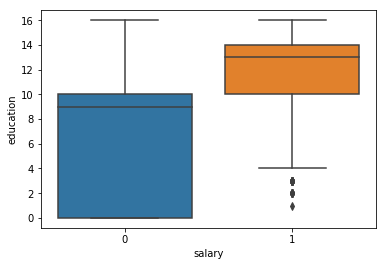

In [43]:
sns.boxplot(x=df['salary'], y=df['education'])

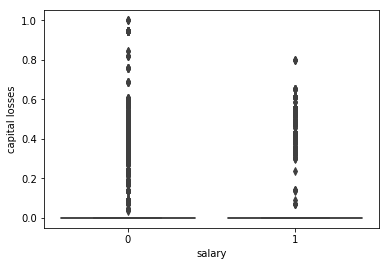

In [237]:
sns.boxplot(x=df['salary'], y=df['capital losses'])

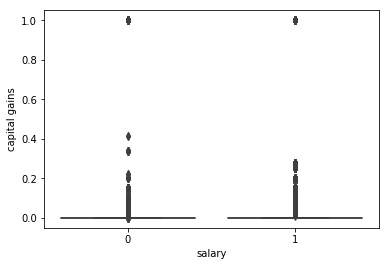

In [238]:
sns.boxplot(x=df['salary'], y=df['capital gains'])

/home/m.marzeta/OQA/mb-udata-tools/env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/m.marzeta/OQA/mb-udata-tools/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


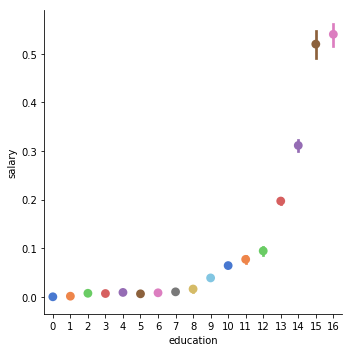

In [42]:
g = sns.factorplot(x="education",y="salary",data=df,palette = "muted")

/Users/maciejmarzeta/env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


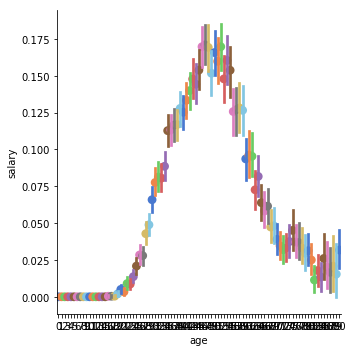

In [240]:
g = sns.factorplot(x="age",y="salary",data=df,palette = "muted")

/Users/maciejmarzeta/env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


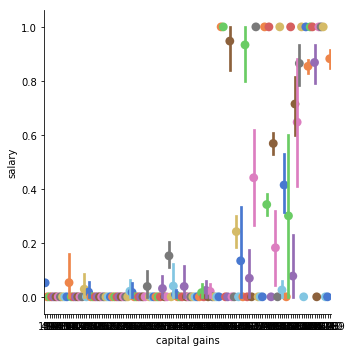

In [28]:
g = sns.factorplot(x="capital gains", y='salary',data=df,palette = "muted")

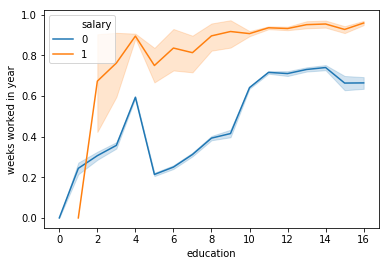

In [241]:
sns.lineplot(x='education', y='weeks worked in year', hue='salary', data=df)

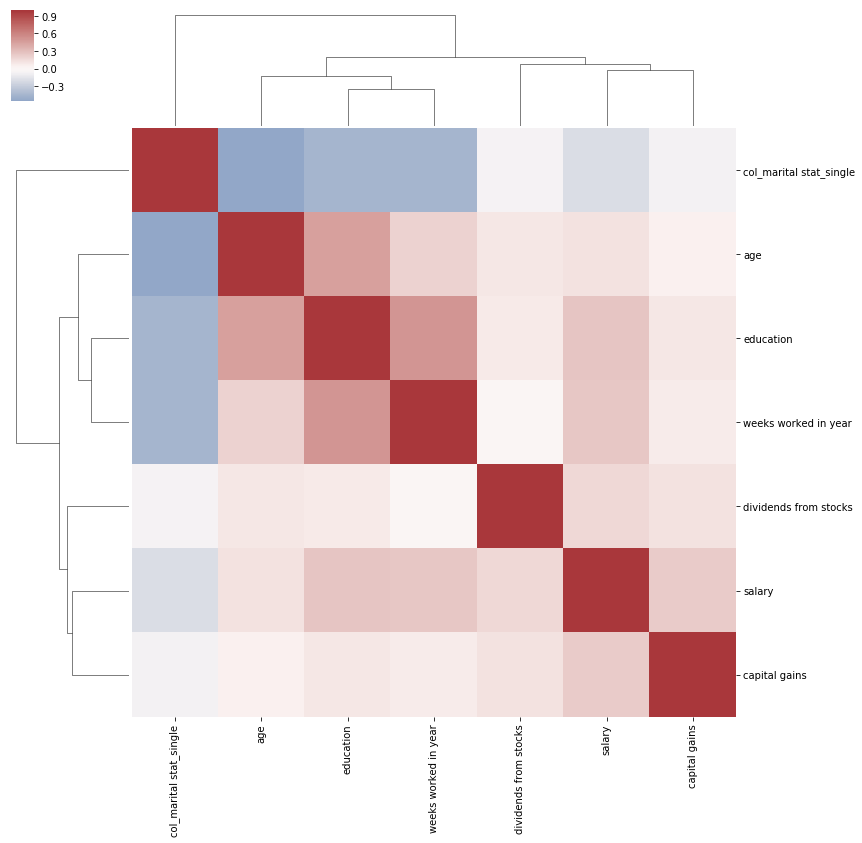

In [242]:
after_reduction = df.filter(['salary', 'education', 'weeks worked in year',
                            'capital gains', 'dividends from stocks', 'col_sex_1',
                            'age', 'col_sex_0', 'col_marital stat_single'])
sns.clustermap(after_reduction.corr(), center=0, cmap="vlag", figsize=(13,13))

Klasteryzacja
TODO. Podać średnie wartości które mają rekordy należące do tych klastrów.

In [80]:
def cluster(dataset, clusters_num):
    numerical_features = dataset.select_dtypes(include=[np.number])

    pca = PCA(n_components=2).fit(numerical_features)
    pca_2d = pca.transform(numerical_features)
    pca_2d_x = [p[0] for p in pca_2d]
    pca_2d_y = [p[1] for p in pca_2d]
    
    kmeans = KMeans(n_clusters=clusters_num).fit(numerical_features)
    
    clusters_centers = pca.transform(kmeans.cluster_centers_)
    clusters_centers_x = [p[0] for p in clusters_centers]
    clusters_centers_y = [p[1] for p in clusters_centers]
    
    labels = kmeans.labels_
    plt.figure(figsize=(15,15))
    plt.scatter(pca_2d_x, pca_2d_y,c=labels)
    plt.scatter(clusters_centers_x, clusters_centers_y, c='red')
    
    return kmeans

In [81]:
def cluster_info(kmeans, categories):
    for cluster in kmeans.cluster_centers_:
        for c, cat in zip(cluster, categories):
            if c > 0.1 or cat == 'salary':
                print("{} {}".format(round(c, 3), cat))
        print("###")


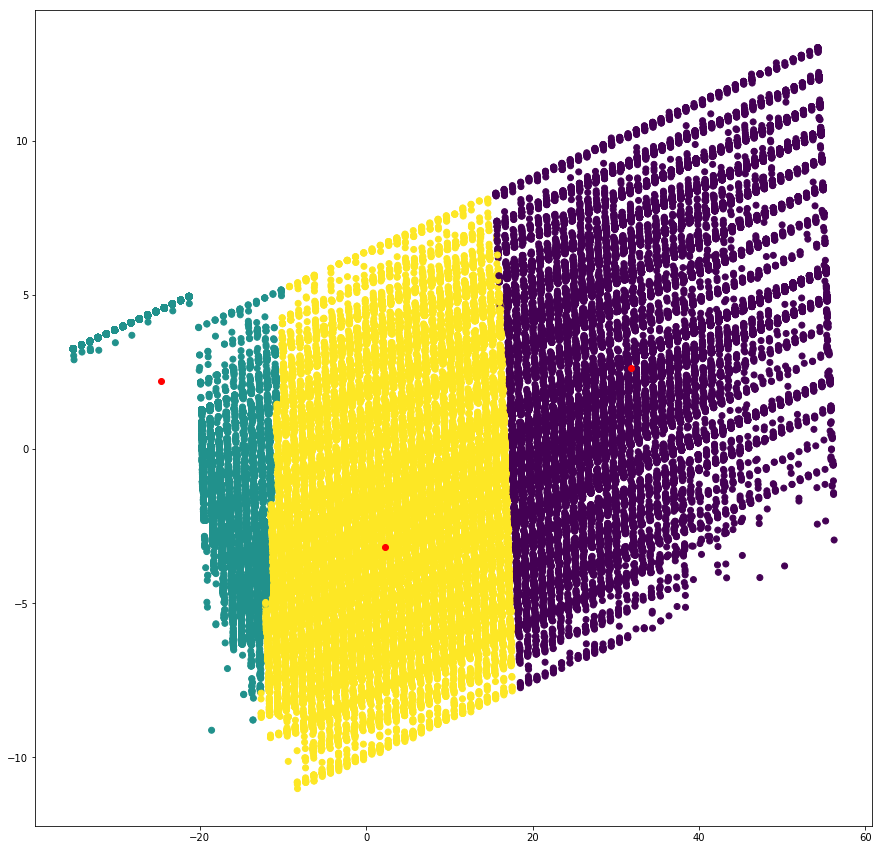

In [82]:
kmeans = cluster(df, 3)


In [90]:
cluster_info(kmeans, df.columns)

26.95 age
11.225 education
4.902 dividends from stocks
0.457 detailed household and family stat
1.996 detailed household summary in household
0.886 migration code-change in msa
0.752 country of birth father
0.505 veterans benefits
0.446 weeks worked in year
0.006 salary
0.162 col_major industry code_ Entertainment
0.172 col_major industry code_ Manufacturing-nondurable goods
0.119 col_major industry code_ Mining
0.193 col_major industry code_ Transportation
0.117 col_major industry code_ Wholesale trade
0.835 col_major occupation code_ Other service
0.507 col_major occupation code_ Technicians and related support
0.395 col_major occupation code_ Transportation and material moving
0.476 col_reason for unemployment_ Other job loser
0.448 col_full or part time employment stat_ Full-time schedules
0.509 col_full or part time employment stat_ Not in labor force
0.491 col_full or part time employment stat_ PT for econ reasons usually FT
###
68.517 age
10.185 education
0.788 dividends from st

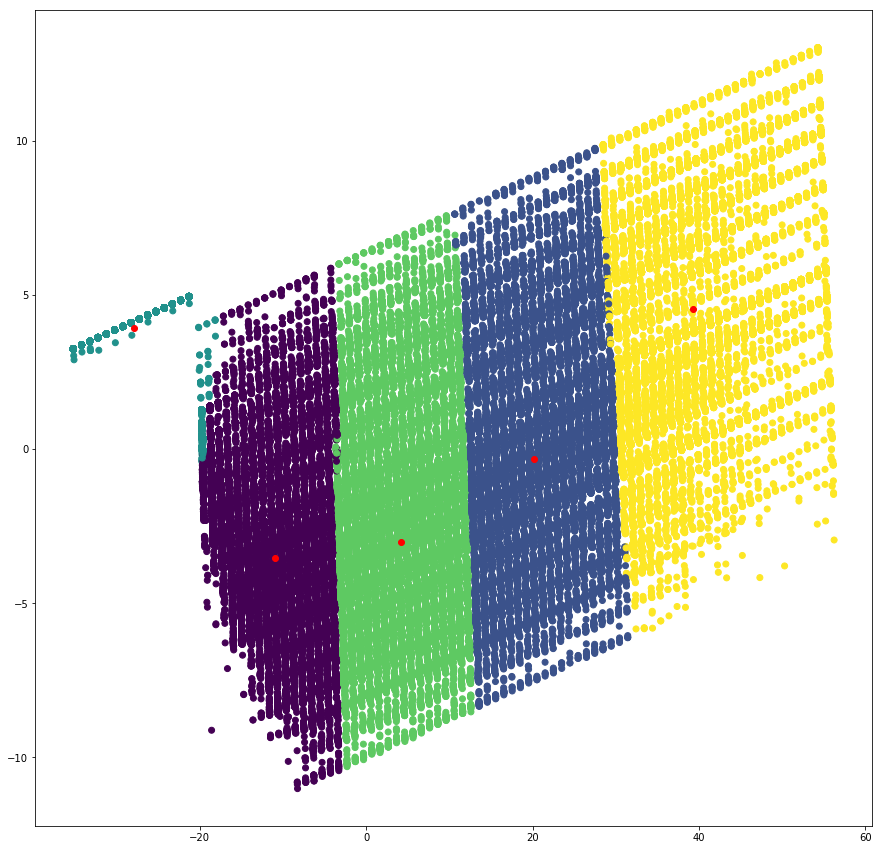

In [84]:
kmeans = cluster(df, 5)

In [85]:
cluster_info(kmeans, df.columns)

23.196 age
8.971 education
2.901 dividends from stocks
0.372 detailed household and family stat
1.997 detailed household summary in household
0.587 migration code-change in msa
0.604 country of birth father
0.325 veterans benefits
0.644 weeks worked in year
0.02 salary
0.197 col_major industry code_ Entertainment
0.111 col_major industry code_ Manufacturing-nondurable goods
0.123 col_major industry code_ Public administration
0.105 col_major industry code_ Wholesale trade
0.11 col_major occupation code_ Handlers equip cleaners etc 
0.817 col_major occupation code_ Other service
0.509 col_major occupation code_ Technicians and related support
0.278 col_major occupation code_ Transportation and material moving
0.145 col_race_ Amer Indian Aleut or Eskimo
0.291 col_reason for unemployment_ Other job loser
0.251 col_full or part time employment stat_ Children or Armed Forces
0.412 col_full or part time employment stat_ Full-time schedules
0.516 col_full or part time employment stat_ Not in 

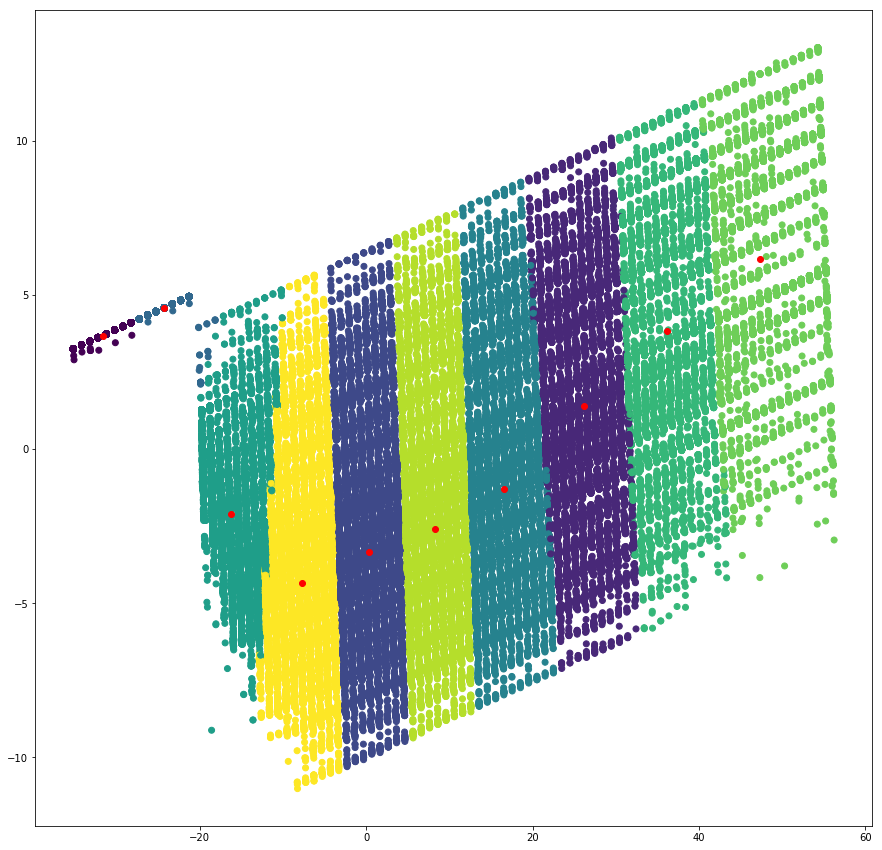

In [86]:
kmeans = cluster(df, 10)

In [87]:
cluster_info(kmeans, df.columns)

3.562 age
1.0 weeks worked in year
0.0 salary
0.13 col_major occupation code_ Handlers equip cleaners etc 
0.792 col_major occupation code_ Other service
1.0 col_major occupation code_ Technicians and related support
1.0 col_full or part time employment stat_ Children or Armed Forces
0.492 col_full or part time employment stat_ Not in labor force
0.508 col_full or part time employment stat_ PT for econ reasons usually FT
###
60.598 age
8.894 education
2.009 dividends from stocks
0.111 detailed household and family stat
1.976 detailed household summary in household
0.5 migration code-change in msa
0.326 country of birth father
0.107 fill inc questionnaire for veteran’s admin
0.748 veterans benefits
0.145 weeks worked in year
0.025 salary
0.875 col_major occupation code_ Other service
0.5 col_major occupation code_ Technicians and related support
0.216 col_major occupation code_ Transportation and material moving
0.241 col_race_ Amer Indian Aleut or Eskimo
0.485 col_reason for unemployme

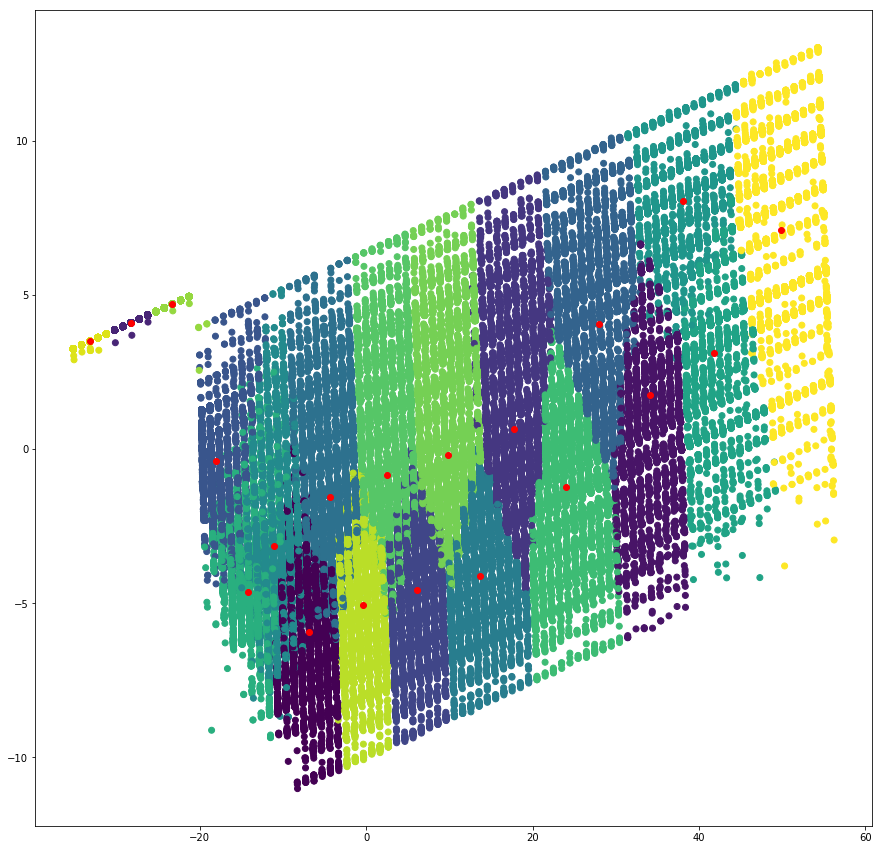

In [88]:
kmeans = cluster(df, 20)

In [89]:
cluster_info(kmeans, df.columns)

26.95 age
11.225 education
4.902 dividends from stocks
0.457 detailed household and family stat
1.996 detailed household summary in household
0.886 migration code-change in msa
0.752 country of birth father
0.505 veterans benefits
0.446 weeks worked in year
0.006 salary
0.162 col_major industry code_ Entertainment
0.172 col_major industry code_ Manufacturing-nondurable goods
0.119 col_major industry code_ Mining
0.193 col_major industry code_ Transportation
0.117 col_major industry code_ Wholesale trade
0.835 col_major occupation code_ Other service
0.507 col_major occupation code_ Technicians and related support
0.395 col_major occupation code_ Transportation and material moving
0.476 col_reason for unemployment_ Other job loser
0.448 col_full or part time employment stat_ Full-time schedules
0.509 col_full or part time employment stat_ Not in labor force
0.491 col_full or part time employment stat_ PT for econ reasons usually FT
###
68.517 age
10.185 education
0.788 dividends from st

Klasyfikacja z użyciem różnych algorytmów klasyfikacji.

In [12]:
df_test = pd.read_csv('tmp_test.csv')
df = pd.read_csv('tmp.csv')

In [13]:
df_test = prepare_data(df_test)
df = prepare_data(df)

In [14]:
df_test['target'] = df_test['salary']
df_test = df_test.drop(['salary'], axis=1)

df['target'] = df['salary']
df = df.drop(['salary'], axis=1)
df.head()

,age,education,wage per hour,member of a labor union,capital gains,capital losses,dividends from stocks,detailed household and family stat,detailed household summary in household,migration code-change in msa,...,col_full or part time employment stat_ Unemployed part- time,col_tax filer stat_ Head of household,col_tax filer stat_ Joint both 65+,col_tax filer stat_ Joint both under 65,col_tax filer stat_ Joint one under 65 & one 65+,col_tax filer stat_ Nonfiler,col_tax filer stat_ Single,col_sex_ Female,col_sex_ Male,target
0,73,9,0.0,NaN,0.0,0.0,0.0,Other Rel 18+ ever marr not in subfamily,Other relative of householder,NaN,...,0,0,0,0,0,1,0,1,0,0
1,58,10,0.0,NaN,0.0,0.0,0.0,Householder,Householder,MSA to MSA,...,0,1,0,0,0,0,0,0,1,0
2,18,6,0.0,NaN,0.0,0.0,0.0,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,...,0,0,0,0,0,1,0,1,0,0
3,9,0,0.0,NaN,0.0,0.0,0.0,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,...,0,0,0,0,0,1,0,1,0,0
4,10,0,0.0,NaN,0.0,0.0,0.0,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,...,0,0,0,0,0,1,0,1,0,0


In [35]:
df = df.select_dtypes(include=[np.number])

Y_train = df.target
X_train = df.drop(['target'], axis=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold


In [36]:
seed = 7
num_folds=10
validation_size=0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(df.drop(['target'], axis=1), 
                                                                df.target, 
                                                                test_size=validation_size, 
                                                                random_state=seed)

In [37]:
# Params for Random Forest
num_trees = 100
max_features = 3

#Spot Check 5 Algorithms (LR, LDA, KNN, CART, GNB, SVM)
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.951754 (0.001564)


/Users/maciejmarzeta/env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/maciejmarzeta/env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/maciejmarzeta/env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/maciejmarzeta/env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/maciejmarzeta/env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/maciejmarzeta/env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warn

LDA: 0.944762 (0.001918)
KNN: 0.943146 (0.001690)
CART: 0.932652 (0.002005)
NB: 0.752591 (0.004833)
RF: 0.951747 (0.001577)


Porównanie algorytmów (trzeba je opisać).

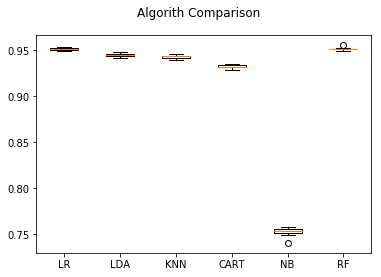

In [38]:
fig = plt.figure()
fig.suptitle('Algorith Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()